# Descriptors and Regression

##### Nikolas Fechner
##### Novartis Institutes for BioMedical Research, Novartis Campus, 4002 Basel, Switzerland

In [1]:
%pylab inline
import pandas as pd
import sklearn
from rdkit import rdBase
import matplotlib as mpl
import numpy as np
import seaborn as sns
print('RDKit version: ',rdBase.rdkitVersion)
print('Pandas version:', pd.__version__)
print('Scikit-Learn version:', sklearn.__version__)
print('Numpy version:', np.__version__)
print('MatplotLib version:', mpl.__version__)
print('Seaborn version',sns.__version__)

Populating the interactive namespace from numpy and matplotlib
RDKit version:  2016.03.4
Pandas version: 0.18.1
Scikit-Learn version: 0.17.1
Numpy version: 1.11.1
MatplotLib version: 1.5.3
Seaborn version 0.7.1


In [2]:
from rdkit.Chem.Draw import IPythonConsole

## Data

Publicly available quantitive solubility data from "Estimation of Aqueous Solubility for a Diverse Set of Organic Compounds Based on Molecular Topology", Jarmo Huuskonen, J. Chem. Inf. Comput. Sci., 2000, 40, 773-777

Training data set obtained from cheminformatics.org: http://cheminformatics.org/datasets/huuskonen/train.smi

Test set obtained from cheminformatics.org: http://cheminformatics.org/datasets/huuskonen/test1.smi

In [3]:
trainSet = pd.read_csv('train.smi',
                       encoding='iso-8859-1',
                       na_values=['?'],
                       delim_whitespace=True,
                       names=['Number','ID','Name','logS','Detail','Detail2','Smiles'])[['Number','ID','Name','logS','Smiles']]

In [4]:
trainSet.head()

,Number,ID,Name,logS,Smiles
0,1,109-66-0,n-pentane,-3.18,CCCCC
1,2,287-92-3,cyclopentane,-2.64,C1CCCC1
2,3,110-54-3,n-hexane,-3.84,CCCCCC
3,4,107-83-5,2-methylpentane,-3.74,CCCC(C)C
4,6,75-83-2,"2,2-dimethylbutane",-3.55,CCC(C)(C)C


In [5]:
from rdkit import Chem
from rdkit.Chem import PandasTools

In [6]:
trainSet.dropna(axis='index',inplace=True)

In [7]:
PandasTools.AddMoleculeColumnToFrame(frame=trainSet, smilesCol='Smiles', molCol='Molecule')

RDKit ERROR: [09:02:07] SMILES Parse Error: syntax error for input: 'n(H)(c(c(c1cccc2)ccc3)c3)c12'
RDKit ERROR: [09:02:07] SMILES Parse Error: syntax error for input: 'c1ccc4c(c1)ccc5c3ccc2ccccc2c3n(H)c45'
RDKit ERROR: [09:02:07] SMILES Parse Error: syntax error for input: 'pyri'
RDKit ERROR: [09:02:07] SMILES Parse Error: syntax error for input: 'pyri'
RDKit ERROR: [09:02:07] SMILES Parse Error: syntax error for input: 'O=C(O)CC(c(c(N1(H))ccc2)c2)=C1'
RDKit ERROR: [09:02:07] SMILES Parse Error: syntax error for input: 'pyri'
RDKit ERROR: [09:02:07] SMILES Parse Error: syntax error for input: 'c1ccc2c(C)cn(H)c2c1'
RDKit ERROR: [09:02:07] SMILES Parse Error: syntax error for input: 'c1ccc2n(H)nnc2c1'
RDKit ERROR: [09:02:07] SMILES Parse Error: syntax error for input: 'c1ccc2ccn(H)c2c1'
RDKit ERROR: [09:02:07] Can't kekulize mol 
RDKit ERROR: 
RDKit ERROR: [09:02:07] SMILES Parse Error: syntax error for input: 'N(c(c(N1(H))ccc2)c2)=C1C'
RDKit ERROR: [09:02:07] Can't kekulize mol 
RDKit E

There are a couple of SMILES that could be parsed by RDKit, as well as a few lines with wrong column order (the "pyri" cases).

In [8]:
problematicSmiles = trainSet.ix[trainSet['Molecule'].map(lambda x: x is None)]
problematicSmiles

,Number,ID,Name,logS,Smiles,Molecule
78,98,86-74-8,carbazole,-4.97,n(H)(c(c(c1cccc2)ccc3)c3)c12,None
80,101,239-64-5,"13H-dibenzo(a,i)carbazole",-7.42,c1ccc4c(c1)ccc5c3ccc2ccccc2c3n(H)c45,None
81,102,260-94-6,acridine,-3.67,pyri,None
82,103,578-06-3,1-aminoacridine,-4.22,pyri,None
336,422,87-51-4,indole-3-acetic_acid,-2.07,O=C(O)CC(c(c(N1(H))ccc2)c2)=C1,None
461,578,110-86-1,pyridine,0.76,pyri,None
476,597,83-34-1,3-methylindole,-2.42,c1ccc2c(C)cn(H)c2c1,None
478,599,95-14-7,benzotriazole,-0.78,c1ccc2n(H)nnc2c1,None
482,604,120-72-9,indole,-1.52,c1ccc2ccn(H)c2c1,None
484,607,271-44-3,indazole,-2.16,c2ccc1nncc1c2,None


Let's get rid of those lines

In [9]:
# "trainSet['Molecule'].map(lambda x: x is not None)" is generating a pandas Series with Booleans
#  that can be directly used as a row filter
trainSet = trainSet.ix[trainSet['Molecule'].map(lambda x: x is not None)]

Pandas offers a simple way to get an overall impression of the data statistics

In [10]:
trainSet.describe()

,Number,logS
count,991.000000,991.000000
mean,639.542886,-2.729495
std,375.020355,2.049644
min,1.000000,-11.620000
25%,316.000000,-3.955000
50%,634.000000,-2.470000
75%,949.500000,-1.360000
max,1296.000000,1.580000


But the Violinplot that Seaborn offers is also a nice addition

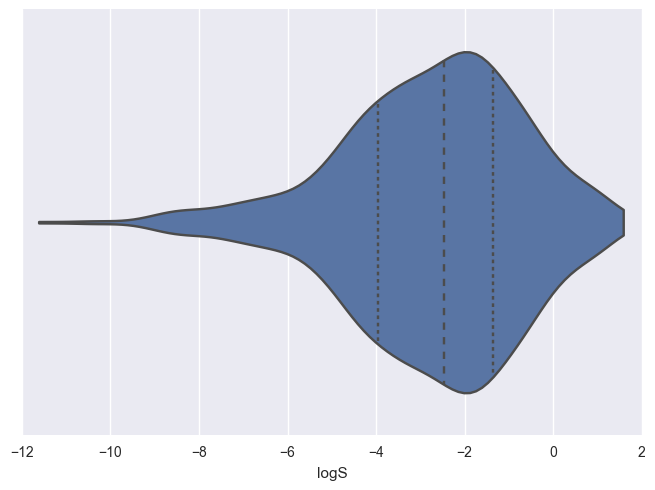

In [11]:
sns.violinplot(trainSet['logS'],cut=0,scale="count", inner="quartile")

In order to build a regression model we have to transform the molecules in vectorial representations that can be used by the desired machine learning algorithms. 
The easiest way to achieve this is by computing a couple of whole molecule descriptors.

Let's just compute all descriptors that RDKit is offering here out of the box:

In [12]:
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
descriptors = list(np.array(Descriptors._descList)[:,0])
print(np.array(Descriptors._descList)[:,0])

['MaxAbsPartialCharge' 'MaxEStateIndex' 'NumRadicalElectrons'
 'MinAbsEStateIndex' 'MaxPartialCharge' 'MolWt' 'MinAbsPartialCharge'
 'HeavyAtomMolWt' 'NumValenceElectrons' 'MaxAbsEStateIndex'
 'MinPartialCharge' 'ExactMolWt' 'MinEStateIndex' 'BalabanJ' 'BertzCT'
 'Chi0' 'Chi0n' 'Chi0v' 'Chi1' 'Chi1n' 'Chi1v' 'Chi2n' 'Chi2v' 'Chi3n'
 'Chi3v' 'Chi4n' 'Chi4v' 'HallKierAlpha' 'Ipc' 'Kappa1' 'Kappa2' 'Kappa3'
 'LabuteASA' 'PEOE_VSA1' 'PEOE_VSA10' 'PEOE_VSA11' 'PEOE_VSA12'
 'PEOE_VSA13' 'PEOE_VSA14' 'PEOE_VSA2' 'PEOE_VSA3' 'PEOE_VSA4' 'PEOE_VSA5'
 'PEOE_VSA6' 'PEOE_VSA7' 'PEOE_VSA8' 'PEOE_VSA9' 'SMR_VSA1' 'SMR_VSA10'
 'SMR_VSA2' 'SMR_VSA3' 'SMR_VSA4' 'SMR_VSA5' 'SMR_VSA6' 'SMR_VSA7'
 'SMR_VSA8' 'SMR_VSA9' 'SlogP_VSA1' 'SlogP_VSA10' 'SlogP_VSA11'
 'SlogP_VSA12' 'SlogP_VSA2' 'SlogP_VSA3' 'SlogP_VSA4' 'SlogP_VSA5'
 'SlogP_VSA6' 'SlogP_VSA7' 'SlogP_VSA8' 'SlogP_VSA9' 'TPSA' 'EState_VSA1'
 'EState_VSA10' 'EState_VSA11' 'EState_VSA2' 'EState_VSA3' 'EState_VSA4'
 'EState_VSA5' 'EState_VSA6' 'EState

In [13]:
calculator = MoleculeDescriptors.MolecularDescriptorCalculator(descriptors)

def computeDescriptors(mol, calculator):
    res = np.array(calculator.CalcDescriptors(mol))
    if not np.all(np.isfinite(res)):
        return None  #make is easier to identify problematic molecules (.e.g infity descriptor values) later 
    return res

In [14]:
#compute the descriptors
trainSet['Descriptors'] = trainSet['Molecule'].map(lambda x: computeDescriptors(x,calculator))
#and remove rows with non-finite descriptor values (seems to be only 1 by comparing the counts)
trainSet = trainSet.ix[trainSet['Descriptors'].map(lambda x: x is not None)]
trainSet.describe()

,Number,logS
count,990.000000,990.000000
mean,638.932323,-2.726606
std,374.716781,2.048659
min,1.000000,-11.620000
25%,315.500000,-3.950000
50%,633.500000,-2.465000
75%,948.500000,-1.360000
max,1296.000000,1.580000


,Number,ID,Name,logS,Smiles,Molecule,Descriptors
0,1,109-66-0,n-pentane,-3.18,CCCCC,,"[0.0653825553794, 2.21180555556, 0.0, 1.34375, -0.0538313154318, 72.151, 0.0538313154318, 60.055, 32.0, 2.21180555556, -0.0653825553794, 72.093900384, 1.34375, 2.19060968716, 7.50977500433, 4.12132034356, 4.12132034356, 4.12132034356, 2.41421356237, 2.41421356237, 2.41421356237, 1.35355339059, 1.35355339059, 0.707106781187, 0.707106781187, 0.353553390593, 0.353553390593, 0.0, 11.2451124978, 5.0, 4.0, 4.0, 34.1990194854, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.1099392682, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.1099392682, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.1099392682, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.2624648688, 0.0, 0.0, 13.8474743994, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8.5, 1.0, 5.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...]"
1,2,287-92-3,cyclopentane,-2.64,C1CCCC1,,"[0.0533059727891, 1.5, 0.0, 1.5, -0.0533059727891, 70.135, 0.0533059727891, 60.055, 30.0, 1.5, -0.0533059727891, 70.07825032, 1.5, 2.08333333333, 11.6096404744, 3.53553390593, 3.53553390593, 3.53553390593, 2.5, 2.5, 2.5, 1.76776695297, 1.76776695297, 1.25, 1.25, 0.883883476483, 0.883883476483, 0.0, 22.886435387, 3.2, 1.44, 0.64, 33.1931883319, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.1041081146, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.1041081146, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.1041081146, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.1041081146, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.5, 1.0, 5.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, ...]"
2,3,110-54-3,n-hexane,-3.84,CCCCCC,,"[0.0653823845981, 2.23180555556, 0.0, 1.355, -0.0535787022524, 86.178, 0.0535787022524, 72.066, 38.0, 2.23180555556, -0.0653823845981, 86.109550448, 1.355, 2.33909231498, 12.0, 4.82842712475, 4.82842712475, 4.82842712475, 2.91421356237, 2.91421356237, 2.91421356237, 1.70710678119, 1.70710678119, 0.957106781187, 0.957106781187, 0.5, 0.5, 0.0, 20.9863008571, 6.0, 5.0, 4.0, 40.5639615998, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 39.5307608911, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 39.5307608911, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 39.5307608911, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 25.6832864917, 0.0, 0.0, 13.8474743994, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 1.0, 6.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...]"
3,4,107-83-5,2-methylpentane,-3.74,CCCC(C)C,,"[0.065372598179, 2.25347222222, 0.0, 0.898148148148, -0.0471426354376, 86.178, 0.0471426354376, 72.066, 38.0, 2.25347222222, -0.065372598179, 86.109550448, 0.898148148148, 2.6272148479, 21.2192809489, 4.99156383156, 4.99156383156, 4.99156383156, 2.77005561003, 2.77005561003, 2.77005561003, 2.18252198471, 2.18252198471, 0.866025403784, 0.866025403784, 0.57735026919, 0.57735026919, 0.0, 14.8344668561, 6.0, 3.2, 4.0, 40.5639615998, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.6128548449, 5.91790604616, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.91790604616, 33.6128548449, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.91790604616, 33.6128548449, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.91790604616, 12.8416432459, 0.0, 0.0, 20.7712115991, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.3333333333, 1.0, 6.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...]"
4,6,75-83-2,"2,2-dimethylbutane",-3.55,CCC(C)(C)C,,"[0.0648833608385, 2.24305555556, 0.0, 0.541666666667, -0.0385231176563, 86.178, 0.0385231176563, 72.066, 38.0, 2.24305555556, -0.0648833608385, 86.109550448, 0.541666666667, 3.16848987267, 29.7931939045, 5.20710678119, 5.20710678119, 5.20710678119, 2.56066017178, 2.56066017178, 2.56066017178, 2.91421356237, 2.91421356237, 1.06066017178, 1.06066017178, 0.0, 0.0, 0.0, 12.1647970364, 6.0, 1.63265306122, 4.0, 40.5639615998, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.1157704217, 5.4149904694, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.41499
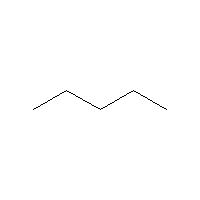
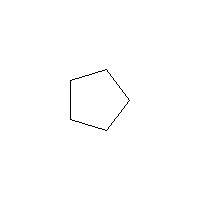
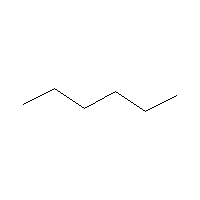
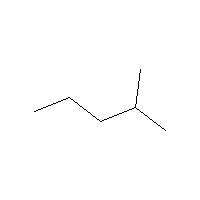
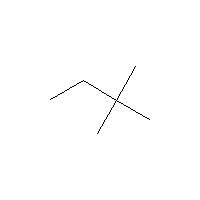

In [15]:
trainSet.head()

## Descriptive Modelling - Revealing patterns in the data

Coefficient of determination R^2 (LR):  0.934784973237
MSE (LR):  0.27343128474
Coefficient of determination R^2 (Default Tree):  0.999983220253
MSE (Default Tree):  7.03535353535e-05
Coefficient of determination R^2 (Custom Tree):  0.913311711869
MSE (Custom Tree):  0.363463624444


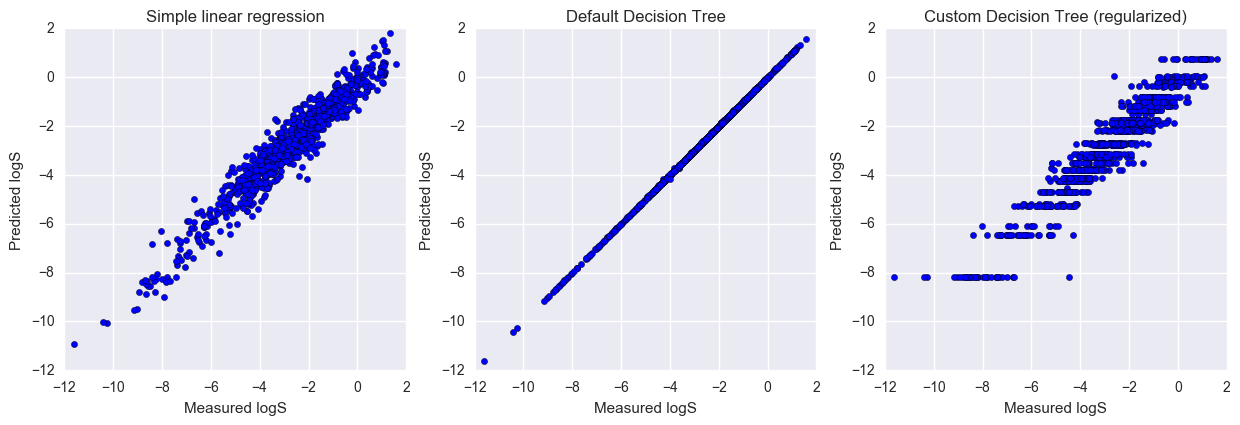

In [16]:
figure,(ax1,ax2,ax3) = pyplot.subplots(1,3)
figure.set_size_inches(15,15)
#simple linear regression
from sklearn import linear_model

simple_linearreg = linear_model.LinearRegression(normalize=True)
simple_linearreg.fit(trainSet['Descriptors'].tolist(),trainSet['logS'])
simple_prediction = simple_linearreg.predict(trainSet['Descriptors'].tolist())
ax1.scatter(trainSet['logS'],simple_prediction)
ax1.set_aspect('equal')
ax1.set_title('Simple linear regression')
ax1.set_xlabel('Measured logS')
ax1.set_ylabel('Predicted logS')
ax1.set_xlim(-12,2)
ax1.set_ylim(-12,2)

#simple decision tree regression
from sklearn import tree
simple_tree = tree.DecisionTreeRegressor()
simple_tree.fit(trainSet['Descriptors'].tolist(),trainSet['logS'])
simple_treeprediction = simple_tree.predict(trainSet['Descriptors'].tolist())
ax2.scatter(trainSet['logS'],simple_treeprediction)
ax2.set_aspect('equal')
ax2.set_title('Default Decision Tree')
ax2.set_xlabel('Measured logS')
ax2.set_ylabel('Predicted logS')
ax2.set_xlim(-12,2)
ax2.set_ylim(-12,2)

#custom decision tree regression
from sklearn import tree
custom_tree = tree.DecisionTreeRegressor(max_depth=10, min_samples_split = 50)
custom_tree.fit(trainSet['Descriptors'].tolist(),trainSet['logS'])
custom_treeprediction = custom_tree.predict(trainSet['Descriptors'].tolist())
ax3.scatter(trainSet['logS'],custom_treeprediction)
ax3.set_aspect('equal')
ax3.set_title('Custom Decision Tree (regularized)')
ax3.set_xlabel('Measured logS')
ax3.set_ylabel('Predicted logS')
ax3.set_xlim(-12,2)
ax3.set_ylim(-12,2)

from sklearn.metrics import mean_squared_error
print('Coefficient of determination R^2 (LR): ',simple_linearreg.score(trainSet['Descriptors'].tolist(),trainSet['logS']))
print('MSE (LR): ',(mean_squared_error(trainSet['logS'],simple_prediction)))
print('Coefficient of determination R^2 (Default Tree): ',(simple_tree.score(trainSet['Descriptors'].tolist(),trainSet['logS'])))
print('MSE (Default Tree): ',(mean_squared_error(trainSet['logS'],simple_treeprediction)))
print('Coefficient of determination R^2 (Custom Tree): ',(custom_tree.score(trainSet['Descriptors'].tolist(),trainSet['logS'])))
print('MSE (Custom Tree): ',(mean_squared_error(trainSet['logS'],custom_treeprediction)))
#print zip(simple_prediction,custom_prediction)

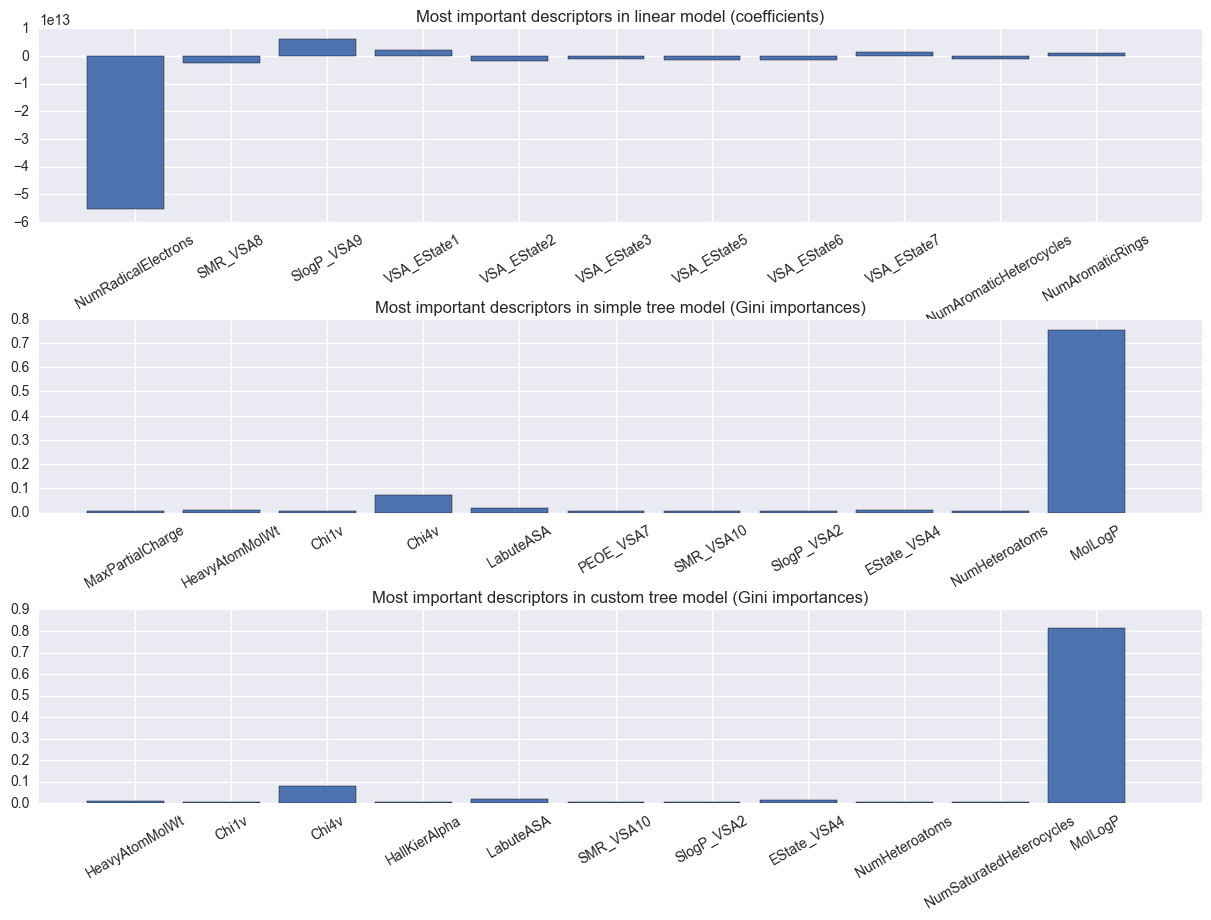

In [17]:
def createImportancePlot(splt,desc,importances,caption):
    labels = []
    weights = []
    threshold = sort([abs(w) for w in importances])[max(-11,-(len(importances)))]
    for d in zip(desc,importances):
        if abs(d[1]) >= threshold:
            labels.append(d[0])
            weights.append(d[1])
    xlocations = np.array(range(len(labels)))+0.5
    width = 0.8
    splt.bar(xlocations, weights, width=width)
    splt.set_xticks([r+1 for r in range(len(labels))])
    splt.set_xticklabels(labels,rotation=30,)
    splt.set_xlim(0, xlocations[-1]+width*2)
    splt.set_title(caption)
    splt.get_xaxis().tick_bottom()
    splt.get_yaxis().tick_left()

figure,(plt1,plt2,plt3) = pyplot.subplots(3,1)
figure.set_size_inches(15,10)
figure.subplots_adjust(hspace=0.5)
imp = simple_linearreg.coef_
createImportancePlot(plt1,descriptors,imp,"Most important descriptors in linear model (coefficients)")
imp2 = simple_tree.feature_importances_ #Gini importances
createImportancePlot(plt2,descriptors,imp2,"Most important descriptors in simple tree model (Gini importances)")
imp3 = custom_tree.feature_importances_ #Gini importances
createImportancePlot(plt3,descriptors,imp3,"Most important descriptors in custom tree model (Gini importances)")


Some descriptors seem to have a quite significant influence on the prediction. Let's check if there is a direct correlation:

Pearson Correlation (MolLogP):  -0.849220563281
Pearson Correlation (LabuteASA):  -0.658654573541
Pearson Correlation (HeavyAtomCount):  -0.571899649331


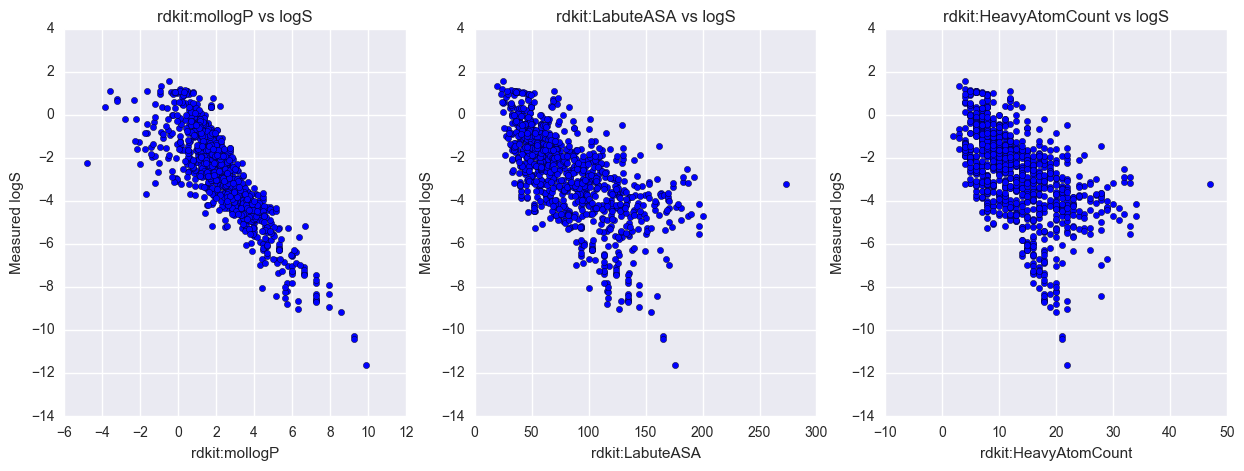

In [18]:
figure,(ax1,ax2,ax3) = pyplot.subplots(1,3)
figure.set_size_inches(15,5)

#inspect logP contribution
from scipy.stats.stats import pearsonr
ind = descriptors.index('MolLogP')
logP = [d[ind] for d in trainSet['Descriptors']]
ax1.scatter(logP,trainSet['logS'])
ax1.set_title('rdkit:mollogP vs logS')
ax1.set_xlabel('rdkit:mollogP')
ax1.set_ylabel('Measured logS')

ax2.scatter([d[descriptors.index('LabuteASA')] for d in trainSet['Descriptors']],trainSet['logS'])
ax2.set_title('rdkit:LabuteASA vs logS')
ax2.set_xlabel('rdkit:LabuteASA')
ax2.set_ylabel('Measured logS')

ax3.scatter([d[descriptors.index('HeavyAtomCount')] for d in trainSet['Descriptors']],trainSet['logS'])
ax3.set_title('rdkit:HeavyAtomCount vs logS')
ax3.set_xlabel('rdkit:HeavyAtomCount')
ax3.set_ylabel('Measured logS')

print('Pearson Correlation (MolLogP): ',pearsonr(logP,trainSet['logS'])[0])
print('Pearson Correlation (LabuteASA): ',pearsonr([d[descriptors.index('LabuteASA')] for d in trainSet['Descriptors']],trainSet['logS'])[0])
print('Pearson Correlation (HeavyAtomCount): ',pearsonr([d[descriptors.index('HeavyAtomCount')] for d in trainSet['Descriptors']],trainSet['logS'])[0])

## Predictive Modelling - Making predictions on new data

So far we only looked at the training data set and we can't be sure if the models can be used to make reliable assumptions about new data points.

RDKit ERROR: [09:02:17] SMILES Parse Error: syntax error for input: 'diaz'
RDKit ERROR: [09:02:17] SMILES Parse Error: syntax error for input: 'c1cccn1(H)'
RDKit ERROR: [09:02:17] Can't kekulize mol 
RDKit ERROR: 
RDKit ERROR: [09:02:17] Can't kekulize mol 
RDKit ERROR: 
RDKit ERROR: [09:02:17] SMILES Parse Error: syntax error for input: 'c1ccc2c(CC(CC)N)cn(H)c2c1'
RDKit ERROR: [09:02:17] SMILES Parse Error: syntax error for input: 'OC(=O)C2=C(CSC3C(NC(=O)Cc1cccs1)C(=O)N23)Cn4(H)ccccc4'


,Number,logS
count,248.000000,248.000000
mean,639.995968,-2.871976
std,373.406525,2.039783
min,5.000000,-9.150000
25%,319.750000,-4.110000
50%,633.500000,-2.605000
75%,954.250000,-1.537500
max,1295.000000,1.130000


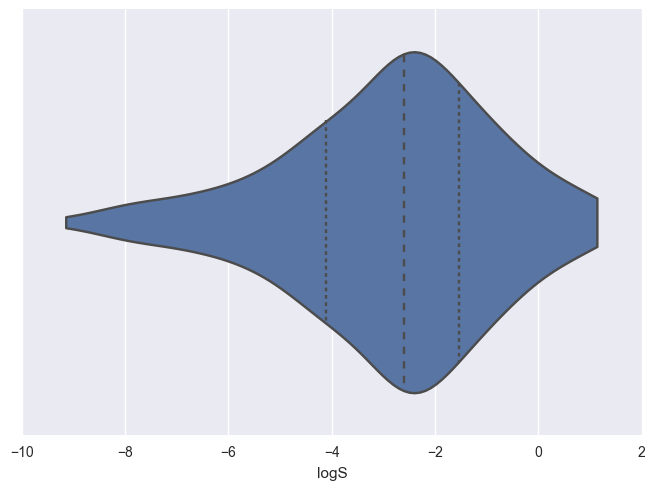

In [19]:
#Load the test same using the same preparation steps as before.
testSet = pd.read_csv('test1.smi',encoding='iso-8859-1',na_values=['?'],delim_whitespace=True, names=['Number','ID','Name','logS','Detail','Detail2','Smiles'])[['Number','ID','Name','logS','Smiles']]
testSet.dropna(axis='index',inplace=True)
PandasTools.AddMoleculeColumnToFrame(frame=testSet, smilesCol='Smiles', molCol='Molecule')
testSet = testSet.ix[testSet['Molecule'].map(lambda x: x is not None)]
testSet['Descriptors'] = testSet['Molecule'].map(lambda x: computeDescriptors(x,calculator))
testSet = testSet.ix[testSet['Descriptors'].map(lambda x: x is not None)]
sns.violinplot(testSet['logS'],cut=0,scale="count", inner="quartile")
testSet.describe()

Apply the created models on the external test data to check wether they can be used for real predictions.

Coefficient of determination R^2 (LR):  0.90741562228
MSE (LR):  0.383663961303
Coefficient of determination R^2 (Default Tree):  0.81042907021
MSE (Default Tree):  0.785570262097
Coefficient of determination R^2 (Custom Tree):  0.851386666487
MSE (Custom Tree):  0.615844504682


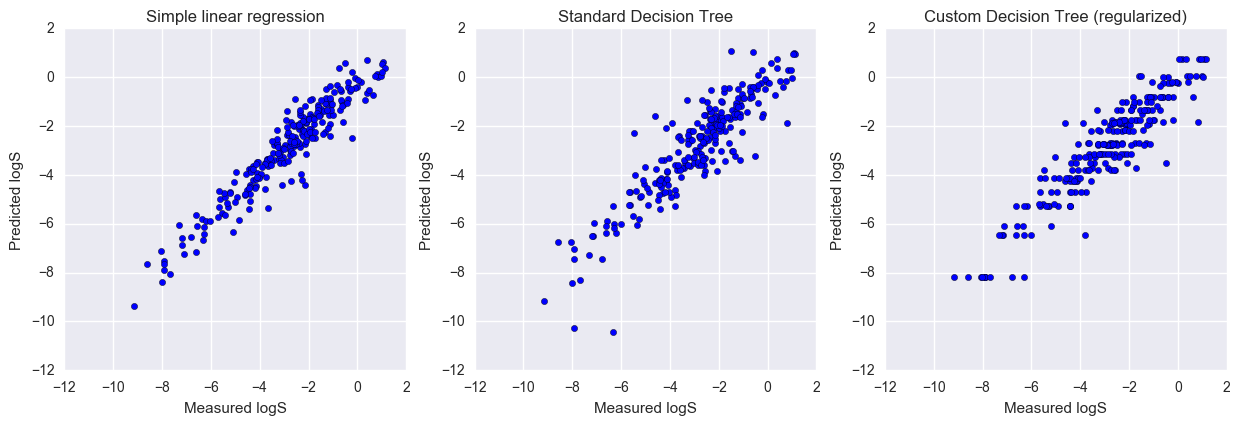

In [20]:
figure,(plt1,plt2,plt3) = pyplot.subplots(1,3)
figure.set_size_inches(15,15)
#simple linear regression
from sklearn import linear_model

simple_ext_prediction = simple_linearreg.predict(testSet['Descriptors'].tolist())
plt1.scatter(testSet['logS'],simple_ext_prediction)
plt1.set_aspect('equal')
plt1.set_title('Simple linear regression')
plt1.set_xlabel('Measured logS')
plt1.set_ylabel('Predicted logS')
plt1.set_xlim(-12,2)
plt1.set_ylim(-12,2)

#simple decision tree regression
simple_tree_ext_prediction = simple_tree.predict(testSet['Descriptors'].tolist())
plt2.scatter(testSet['logS'],simple_tree_ext_prediction)
plt2.set_aspect('equal')
plt2.set_title('Standard Decision Tree')
plt2.set_xlabel('Measured logS')
plt2.set_ylabel('Predicted logS')
plt2.set_xlim(-12,2)
plt2.set_ylim(-12,2)

#custom decision tree regression
custom_tree_ext_prediction = custom_tree.predict(testSet['Descriptors'].tolist())
plt3.scatter(testSet['logS'],custom_tree_ext_prediction)
plt3.set_aspect('equal')
plt3.set_title('Custom Decision Tree (regularized)')
plt3.set_xlabel('Measured logS')
plt3.set_ylabel('Predicted logS')
plt3.set_xlim(-12,2)
plt3.set_ylim(-12,2)

from sklearn.metrics import mean_squared_error
print('Coefficient of determination R^2 (LR): ',(simple_linearreg.score(testSet['Descriptors'].tolist(),testSet['logS'])))
print( 'MSE (LR): ',(mean_squared_error(testSet['logS'],simple_ext_prediction)))
print( 'Coefficient of determination R^2 (Default Tree): ',(simple_tree.score(testSet['Descriptors'].tolist(),testSet['logS'])))
print( 'MSE (Default Tree): ',(mean_squared_error(testSet['logS'],simple_tree_ext_prediction)))
print( 'Coefficient of determination R^2 (Custom Tree): ',(custom_tree.score(testSet['Descriptors'].tolist(),testSet['logS'])))
print( 'MSE (Custom Tree): ',(mean_squared_error(testSet['logS'],custom_tree_ext_prediction)))

Fitting 10 folds for each of 64 candidates, totalling 640 fits


[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 199 tasks       | elapsed:    2.4s
[Parallel(n_jobs=1)]: Done 449 tasks       | elapsed:    8.2s
[Parallel(n_jobs=1)]: Done 640 out of 640 | elapsed:   13.1s finished


Best score:  0.848884347886
Training set performance using best parameters  {'min_samples_split': 32, 'max_depth': 10, 'min_samples_leaf': 10}
Coefficient of determination R^2 (Internal):  0.925061444982
MSE (Internal):  0.314199754141
Coefficient of determination R^2 (External):  0.861008772448
MSE (External):  0.575971089966


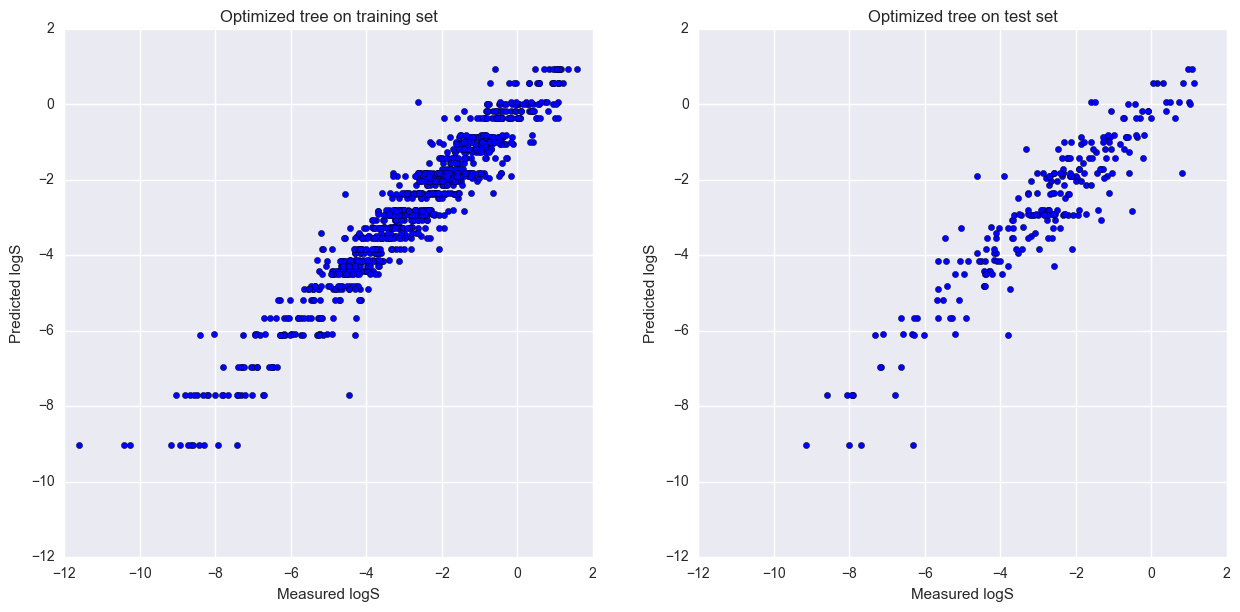

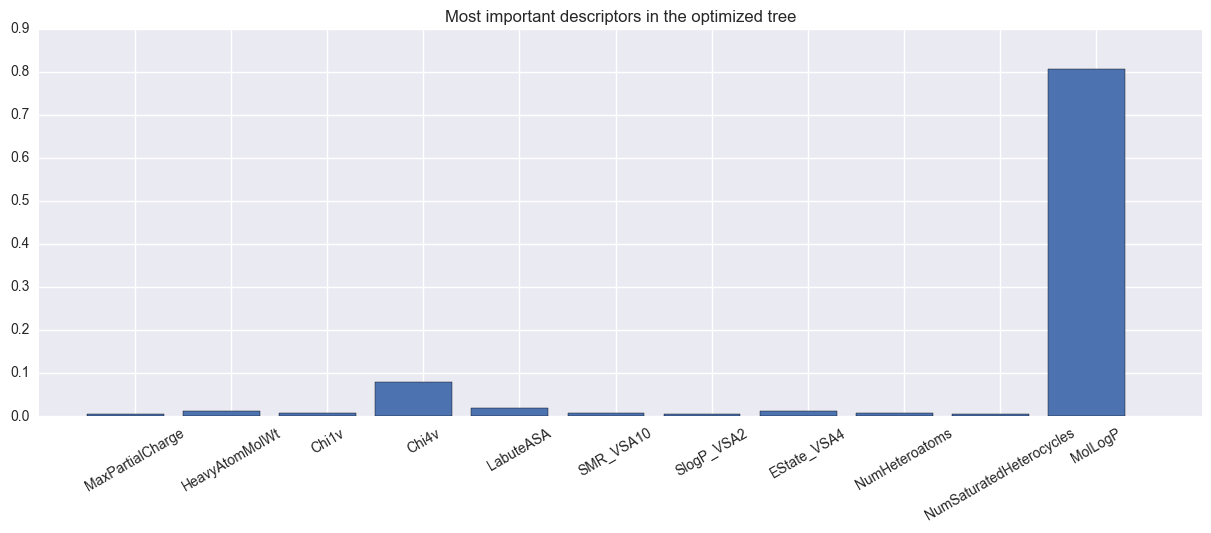

In [21]:
from sklearn.cross_validation import KFold
from sklearn.grid_search import GridSearchCV
params = {'max_depth':[2,5,10,20],'min_samples_split':[2,8,32,128],'min_samples_leaf':[1,2,5,10]}
cv = KFold(n=len(trainSet['Descriptors'].tolist()),n_folds=10,shuffle=True)
gs = GridSearchCV(simple_tree, params, cv=cv,verbose=1,refit=True)
gs.fit(trainSet['Descriptors'].tolist(), trainSet['logS'])
print('Best score: ',gs.best_score_)
print('Training set performance using best parameters ',gs.best_params_)
best_treemodel = gs.best_estimator_
figure,(plt1,plt2) = pyplot.subplots(1,2)
figure.set_size_inches(15,15)
#training set evaluation
best_tree_int_prediction = best_treemodel.predict(trainSet['Descriptors'].tolist())
plt1.scatter(trainSet['logS'],best_tree_int_prediction)
plt1.set_aspect('equal')
plt1.set_title('Optimized tree on training set')
plt1.set_xlabel('Measured logS')
plt1.set_ylabel('Predicted logS')
plt1.set_xlim(-12,2)
plt1.set_ylim(-12,2)

#test set evaluation
best_tree_ext_prediction = best_treemodel.predict(testSet['Descriptors'].tolist())
plt2.scatter(testSet['logS'],best_tree_ext_prediction)
plt2.set_aspect('equal')
plt2.set_title('Optimized tree on test set')
plt2.set_xlabel('Measured logS')
plt2.set_ylabel('Predicted logS')
plt2.set_xlim(-12,2)
plt2.set_ylim(-12,2)

print('Coefficient of determination R^2 (Internal): ',(best_treemodel.score(trainSet['Descriptors'].tolist(),trainSet['logS'])))
print('MSE (Internal): ',(mean_squared_error(trainSet['logS'],best_tree_int_prediction)))
print('Coefficient of determination R^2 (External): ',(best_treemodel.score(testSet['Descriptors'].tolist(),testSet['logS'])))
print('MSE (External): ',(mean_squared_error(testSet['logS'],best_tree_ext_prediction)))
fig,a = pyplot.subplots(1,1)
fig.set_size_inches(15,5)
createImportancePlot(a,descriptors,best_treemodel.feature_importances_,"Most important descriptors in the optimized tree")

Still, the simple linear regression does seem to work best, even without tunable parameters. 

Assuming linear regression is the way to go forward - what about the more sophisticated variants like LASSO or Elastic Net?

In [22]:
from sklearn.linear_model import Lasso,LassoCV


Explained variance (Internal):  0.879059809698
MSE (Internal):  0.507073802656
Explained variance (External):  0.867326137071
MSE (External):  0.549792319896


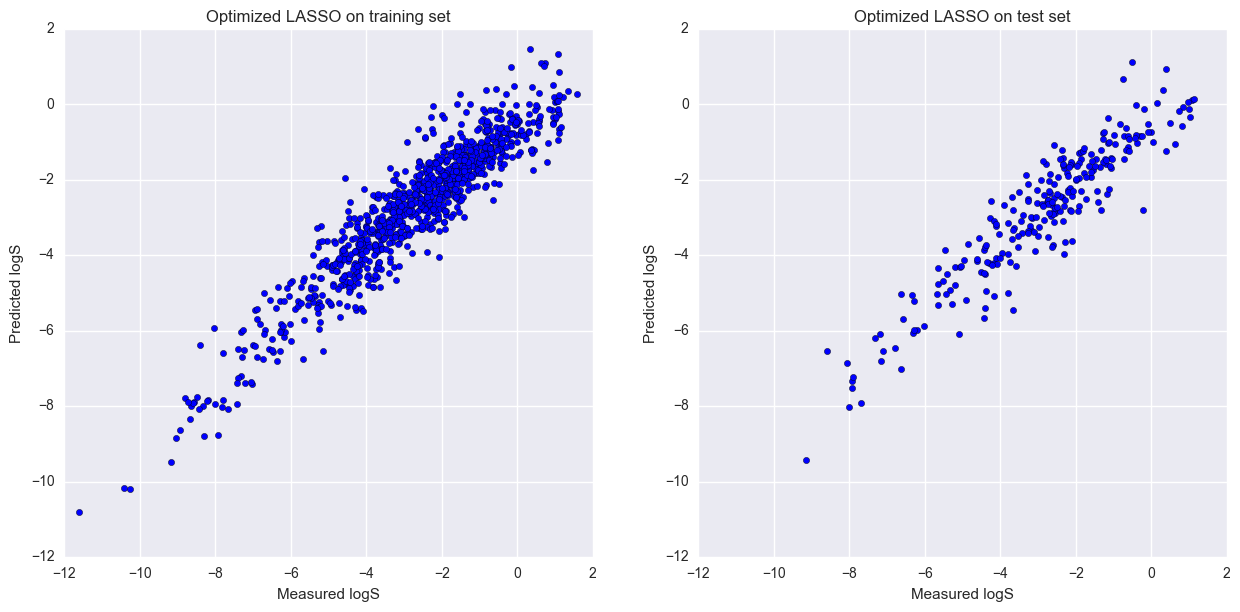

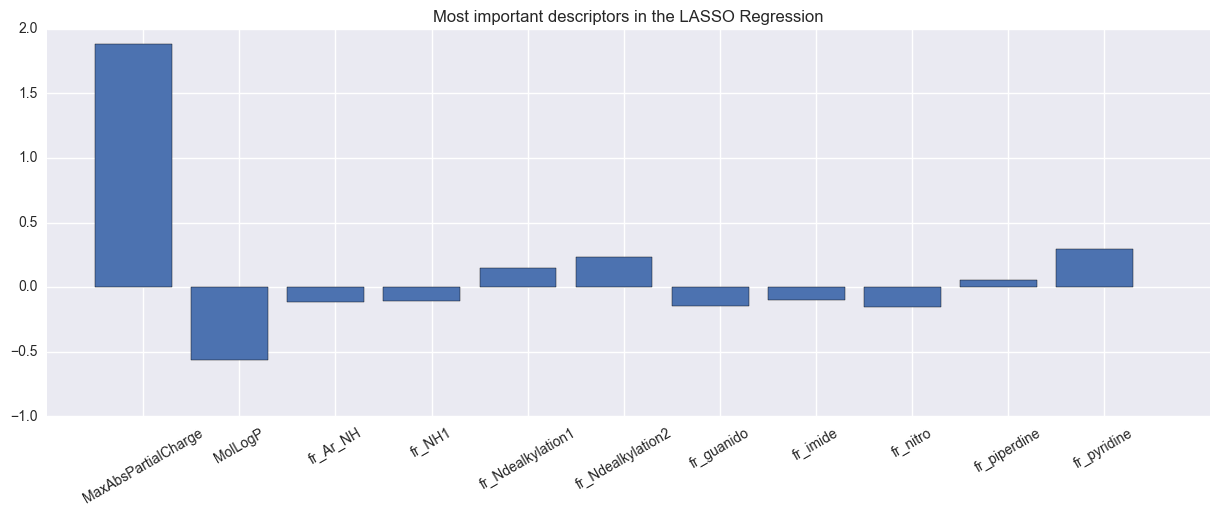

In [23]:
from sklearn.cross_validation import KFold
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import Lasso
best_lasso = LassoCV(normalize=True,max_iter=10000).fit(trainSet['Descriptors'].tolist(), trainSet['logS'])
figure,(plt1,plt2) = pyplot.subplots(1,2)
figure.set_size_inches(15,15)
#training set evaluation
best_int_prediction = best_lasso.predict(trainSet['Descriptors'].tolist())
plt1.scatter(trainSet['logS'],best_int_prediction)
plt1.set_aspect('equal')
plt1.set_title('Optimized LASSO on training set')
plt1.set_xlabel('Measured logS')
plt1.set_ylabel('Predicted logS')
plt1.set_xlim(-12,2)
plt1.set_ylim(-12,2)

#test set evaluation
best_ext_prediction = best_lasso.predict(testSet['Descriptors'].tolist())
plt2.scatter(testSet['logS'],best_ext_prediction)
plt2.set_aspect('equal')
plt2.set_title('Optimized LASSO on test set')
plt2.set_xlabel('Measured logS')
plt2.set_ylabel('Predicted logS')
plt2.set_xlim(-12,2)
plt2.set_ylim(-12,2)

print('Explained variance (Internal): ',(best_lasso.score(trainSet['Descriptors'].tolist(),trainSet['logS'])))
print('MSE (Internal): ',(mean_squared_error(trainSet['logS'],best_int_prediction)))
print('Explained variance (External): ',(best_lasso.score(testSet['Descriptors'].tolist(),testSet['logS'])))
print('MSE (External): ',(mean_squared_error(testSet['logS'],best_ext_prediction)))
fig,a = pyplot.subplots(1,1)
fig.set_size_inches(15,5)
createImportancePlot(a,descriptors,best_lasso.coef_,"Most important descriptors in the LASSO Regression")

Explained variance (Internal):  0.839373147376
MSE (Internal):  0.673470653264
Explained variance (External):  0.831741642824
MSE (External):  0.697252273295


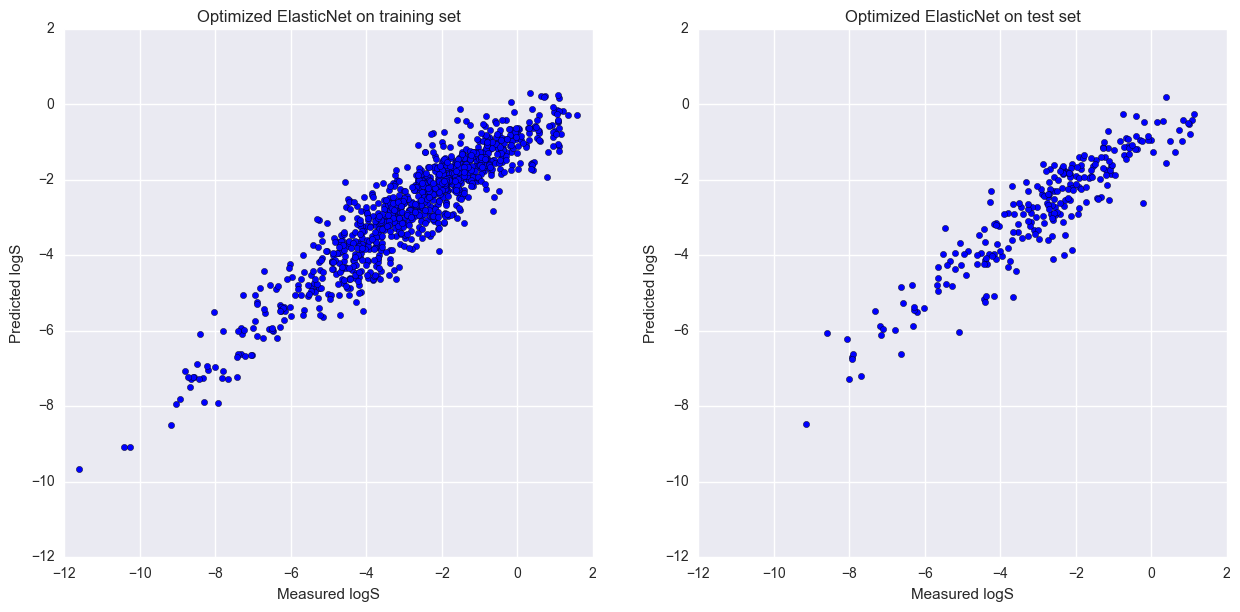

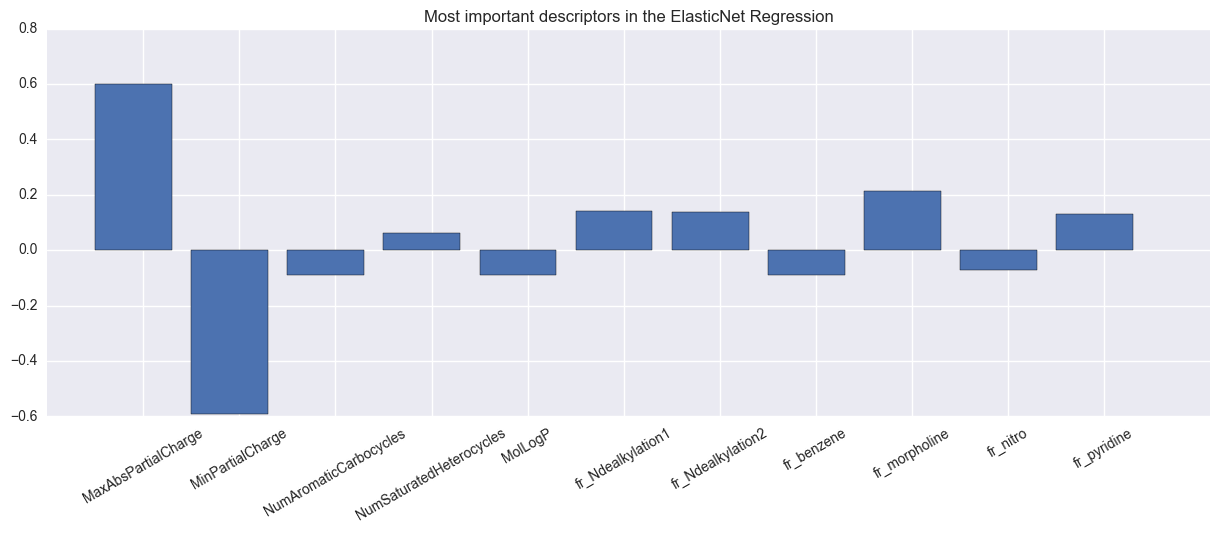

In [24]:
from sklearn.cross_validation import KFold
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import ElasticNetCV
#params = {'alpha':[0.0001,0.001,0.01,0.1,1.0,2.0,4.0,10.0],'normalize':[True], 'warm_start':[False]}
#cv = KFold(n=len(trainSet['Descriptors'].tolist()),n_folds=10,shuffle=True)
#gs = GridSearchCV(Lasso(normalize=True), params, cv=cv,verbose=1,refit=True)
best_elastic = ElasticNetCV(normalize=True,max_iter=10000).fit(trainSet['Descriptors'].tolist(), trainSet['logS'])
#print('Training set performance using best parameters ',gs.best_params_)
#best_lasso = gs.best_estimator_
figure,(plt1,plt2) = pyplot.subplots(1,2)
figure.set_size_inches(15,15)
#training set evaluation
best_int_prediction = best_elastic.predict(trainSet['Descriptors'].tolist())
plt1.scatter(trainSet['logS'],best_int_prediction)
plt1.set_aspect('equal')
plt1.set_title('Optimized ElasticNet on training set')
plt1.set_xlabel('Measured logS')
plt1.set_ylabel('Predicted logS')
plt1.set_xlim(-12,2)
plt1.set_ylim(-12,2)

#test set evaluation
best_ext_prediction = best_elastic.predict(testSet['Descriptors'].tolist())
plt2.scatter(testSet['logS'],best_ext_prediction)
plt2.set_aspect('equal')
plt2.set_title('Optimized ElasticNet on test set')
plt2.set_xlabel('Measured logS')
plt2.set_ylabel('Predicted logS')
plt2.set_xlim(-12,2)
plt2.set_ylim(-12,2)

print('Explained variance (Internal): ',(best_elastic.score(trainSet['Descriptors'].tolist(),trainSet['logS'])))
print('MSE (Internal): ',(mean_squared_error(trainSet['logS'],best_int_prediction)))
print('Explained variance (External): ',(best_elastic.score(testSet['Descriptors'].tolist(),testSet['logS'])))
print('MSE (External): ',(mean_squared_error(testSet['logS'],best_ext_prediction)))
fig,a = pyplot.subplots(1,1)
fig.set_size_inches(15,5)
createImportancePlot(a,descriptors,best_elastic.coef_,"Most important descriptors in the ElasticNet Regression")

Still, it seems for this combination of training test set the simple linear model works best and regularization with respect to both feature weights and feature sparsity does not seem to be very important in this case.

## Feature extraction

[-0.13157161  0.4069777 ]


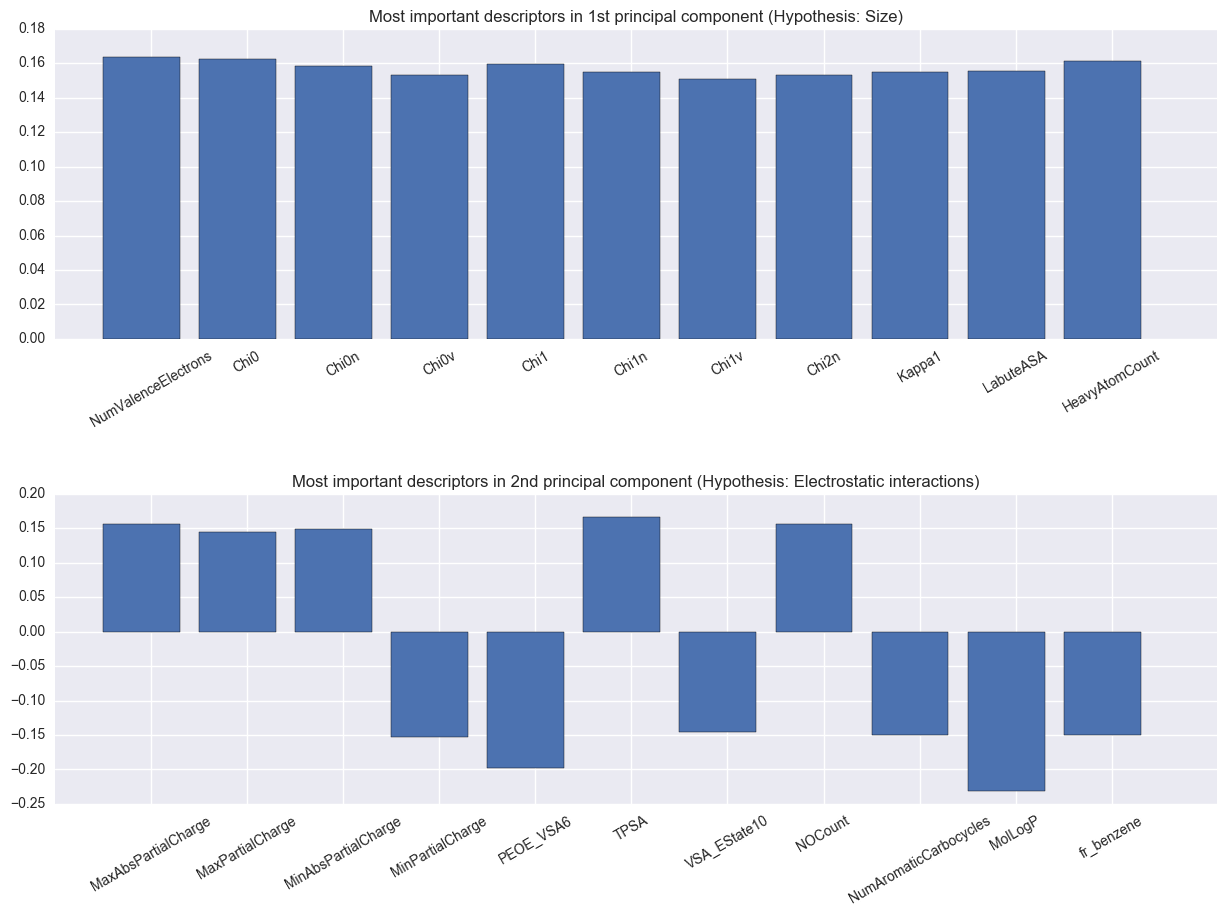

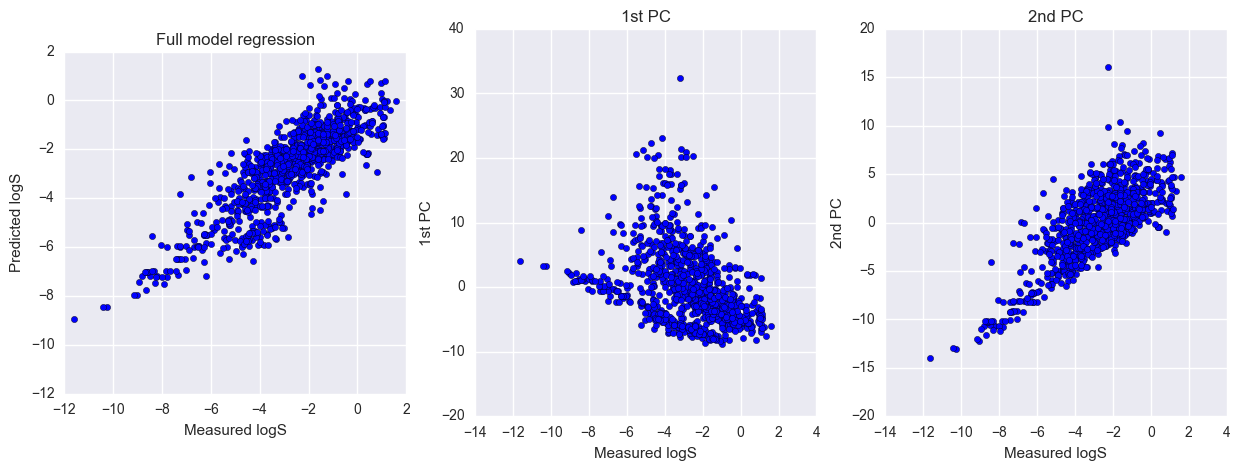

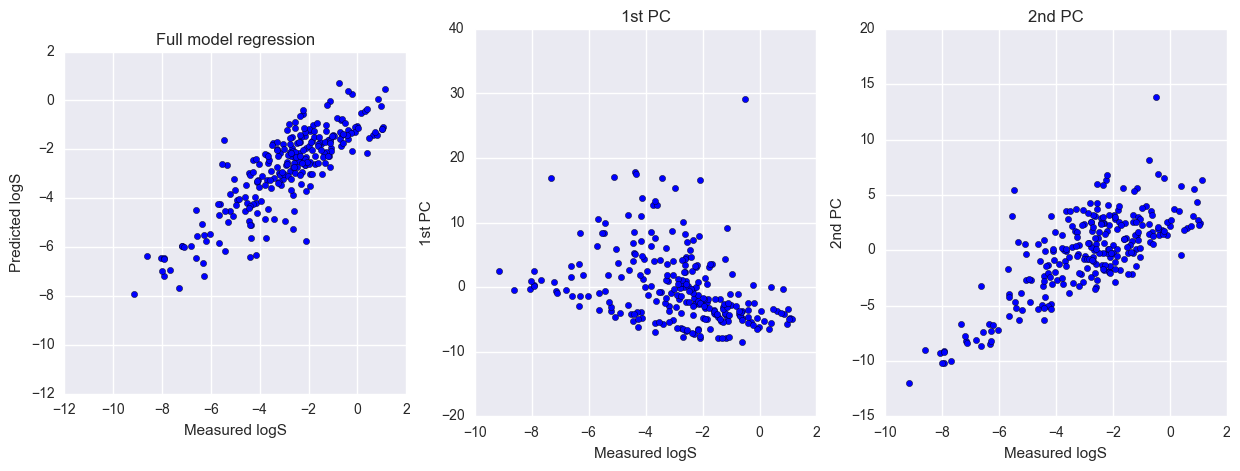

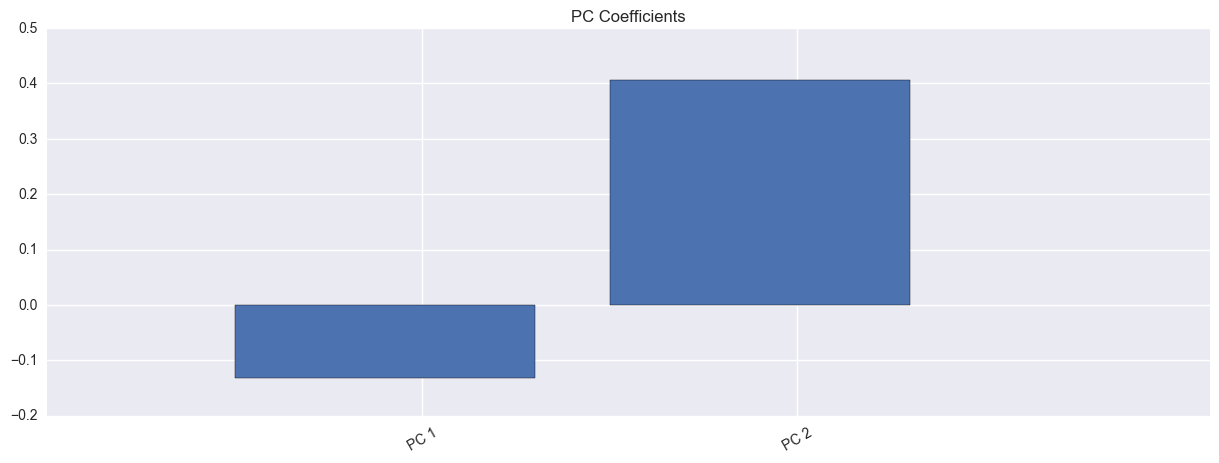

In [25]:
#normalize descriptors
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(trainSet['Descriptors'].tolist())
std_patterns = scaler.transform(trainSet['Descriptors'].tolist())
std_test_patterns = scaler.transform(testSet['Descriptors'].tolist())

#compute pca; provide ten most descriptive principal components
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(std_patterns)
#print 'rel. explained variance per pc',pca.explained_variance_ratio_
pc_patterns = pca.transform(std_patterns)
pc_test = pca.transform(std_test_patterns)
fig,(plt1,plt2) = pyplot.subplots(2,1)
fig.set_size_inches(15,5)
fig.set_size_inches(15,10)
fig.subplots_adjust(hspace=0.5)
createImportancePlot(plt1,descriptors,pca.components_[0],"Most important descriptors in 1st principal component (Hypothesis: Size)")
createImportancePlot(plt2,descriptors,pca.components_[1],"Most important descriptors in 2nd principal component (Hypothesis: Electrostatic interactions)")

#evaluate modelling performance
figure,(plt1,plt2,plt3) = pyplot.subplots(1,3)
figure.set_size_inches(15,5)

#training
pc_linearreg = linear_model.LinearRegression()
pc_linearmodel = pc_linearreg.fit(pc_patterns,trainSet['logS'])
pc_prediction = pc_linearmodel.predict(pc_patterns)
plt1.scatter(trainSet['logS'],pc_prediction)
plt1.set_aspect('equal')
plt1.set_title('Full model regression')
plt1.set_xlabel('Measured logS')
plt1.set_ylabel('Predicted logS')
plt1.set_xlim(-12,2)
plt1.set_ylim(-12,2)

plt2.scatter(trainSet['logS'], [pc[0] for pc in pc_patterns])
plt2.set_title('1st PC')
plt2.set_xlabel('Measured logS')
plt2.set_ylabel('1st PC')


plt3.scatter(trainSet['logS'], [pc[1] for pc in pc_patterns])
plt3.set_title('2nd PC')
plt3.set_xlabel('Measured logS')
plt3.set_ylabel('2nd PC')


#test set
figure,(plt1,plt2,plt3) = pyplot.subplots(1,3)
figure.set_size_inches(15,5)

pc_prediction = pc_linearmodel.predict(pc_test)
plt1.scatter(testSet['logS'],pc_prediction)
plt1.set_aspect('equal')
plt1.set_title('Full model regression')
plt1.set_xlabel('Measured logS')
plt1.set_ylabel('Predicted logS')
plt1.set_xlim(-12,2)
plt1.set_ylim(-12,2)

plt2.scatter(testSet['logS'], [pc[0] for pc in pc_test])
plt2.set_title('1st PC')
plt2.set_xlabel('Measured logS')
plt2.set_ylabel('1st PC')


plt3.scatter(testSet['logS'], [pc[1] for pc in pc_test])
plt3.set_title('2nd PC')
plt3.set_xlabel('Measured logS')
plt3.set_ylabel('2nd PC')

print(pc_linearmodel.coef_)
fig,a = pyplot.subplots(1,1)
fig.set_size_inches(15,5)
createImportancePlot(a,['PC 1','PC 2'],pc_linearmodel.coef_,"PC Coefficients")